# Cox生存分析

* `mydir`：自己的数据
* `ostime_column`: 数据对应的生存时间，不一定非的是OST，也可以是DST、FST等。
* `os`：生存状态，不一定非的是OS，也可以是DS、FS等。

In [1]:
from lifelines import CoxPHFitter
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.model_selection import train_test_split
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.comp1 import fillna

task_type = 'Combined_'
event_col = get_param_in_cwd('event_col', 'label')
duration_col=get_param_in_cwd('duration_col', 'time')
data = pd.read_csv('data/clinical.csv')
# data = normalize_df(data, not_norm='ID'
data

,ID,T,N,M,Degree,DU,BILE,胰周脂肪,脉管癌栓,胰周神经,胰内神经,Sex,Age,OSTime,OS,group
0,1238060,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,56,4.50,0,train
1,1240023,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,39,28.47,0,train
2,1310929,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0,65,5.73,1,test
3,1320927,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1,56,7.30,1,test
4,1322885,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,68,4.87,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2017433,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1,48,22.23,1,test
696,2018527,1.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1,78,5.07,0,train
697,2018539,4.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1,71,16.73,1,train
698,2018734,3.0,2.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,0,72,10.93,1,test


In [2]:
def get_sig(prefix):
    results = [pd.read_csv(f'results/{prefix}_cox_predictions_{subset}.csv')for subset in ['train', 'test']]
    results = pd.concat(results, axis=0)
    return results

mn = {'Path': 'Pathomics', 'Clinical': 'Clinical'}
cnames = ['Age', 'N', 'Degree', ]
cnames = []
data = data[['ID', event_col, duration_col, 'group'] + cnames]
for sig in ['Path', 'Clinical']:
    signature = get_sig(sig)
    signature.columns = ['ID', mn[sig], '-']
    data = pd.merge(data, signature, on='ID', how='inner')
data

,ID,OS,OSTime,group,Pathomics,-_x,Clinical,-_y
0,1238060,0,4.50,train,0.306,49.437,0.841,36.013
1,1240023,0,28.47,train,0.074,77.173,0.602,44.967
2,1310929,1,5.73,test,3.398,14.412,0.757,38.787
3,1320927,1,7.30,test,10.076,8.693,0.886,34.644
4,1322885,0,4.87,train,4.447,12.765,1.063,30.109
...,...,...,...,...,...,...,...,...
695,2017433,1,22.23,test,1.194,22.985,0.541,47.879
696,2018527,0,5.07,train,1.680,19.585,1.319,25.288
697,2018539,1,16.73,train,1.121,23.729,2.315,16.062
698,2018734,1,10.93,test,12.853,7.744,1.996,18.025


In [3]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = 'group'
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = get_param_in_cwd('subsets')
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}{subset}_cox.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(490, 8)，test样本数：(210, 8)


## Cox概览

所有Cox回归的必要数据，主要关注的数据有3个
1. `Concordance`: c-index
2. `exp(coef)`: 每个特征对应的HR，同时也有期对应的95%分位数。
3. `p`: 表示特征是否显著。

In [4]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.01)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group'] and not c.startswith('-')]], 
        duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 490 total observations, 136 right-censored observations>
             duration col = 'OSTime'
                event col = 'OS'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 490
number of events observed = 354
   partial log-likelihood = -1832.89
         time fit was run = 2024-03-28 02:16:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Pathomics   0.13       1.14       0.01             0.11             0.15                 1.11                 1.16
Clinical    0.60       1.82       0.11             0.38             0.82                 1.46                 2.28

            cmp to     z      p   -log2(p)
covariate                                 
Pathomics     0.00 12.60 <0.005     118.56
Clinical      0.00  5.29 <0.005      22.95
---
Concordance = 0.78
Partial AIC = 3669.79
log-likelihood ratio test = 186.69 on 2 df
-log2(p) of ll-ratio test = 134.67

#### 输出每个特征的HR

In [5]:
cph.concordance_index_

0.7813174314657143

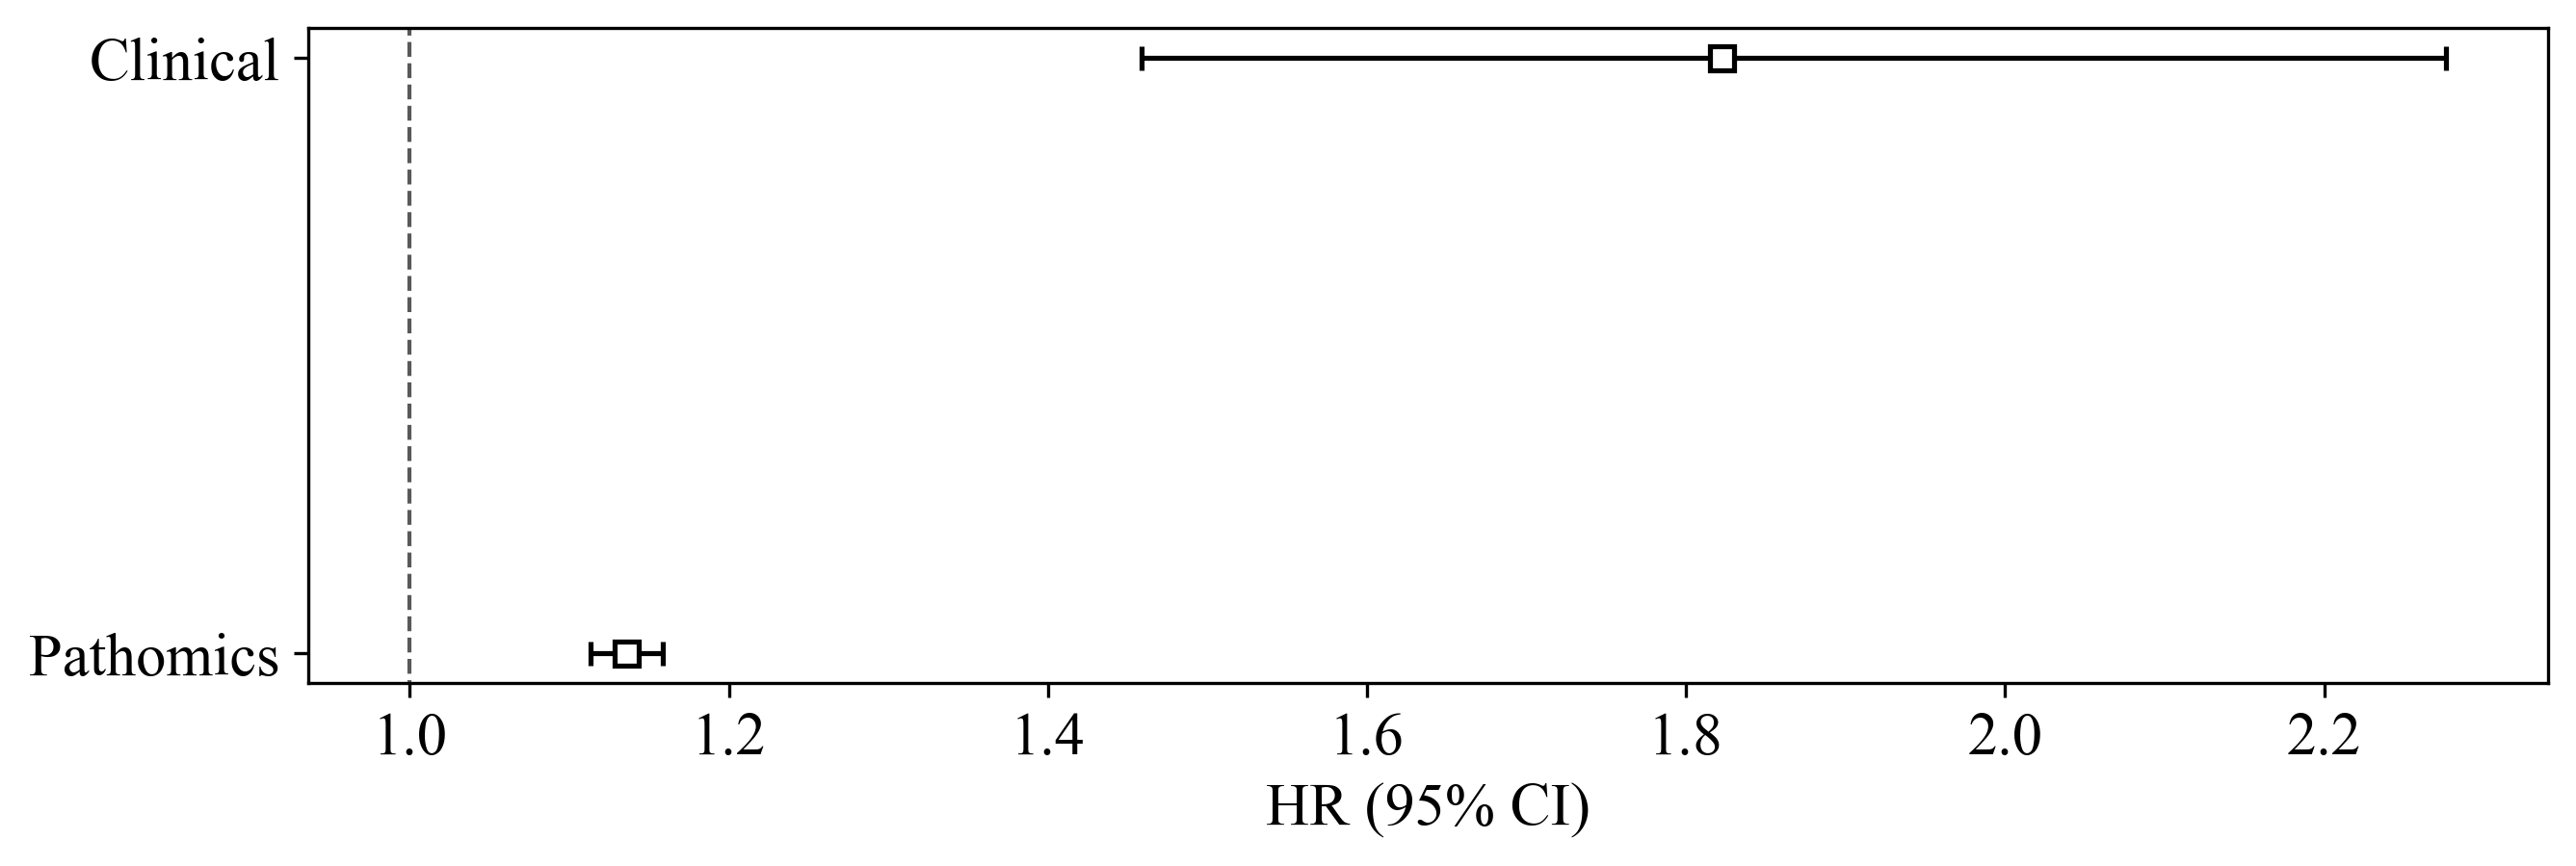

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
cph.plot(hazard_ratios=True)
plt.savefig(f'img/{task_type}_feature_pvalue.svg')
plt.show()

[2024-03-28 10:16:41 - situation.py:  41]	INFO	cffi mode is CFFI_MODE.ANY
[2024-03-28 10:16:41 - situation.py: 227]	INFO	R home found: C:\OnekeyPlatform\onekey_envs\Lib\R
[2024-03-28 10:16:41 - embedded.py:  20]	INFO	Default options to initialize R: rpy2, --quiet, --no-save


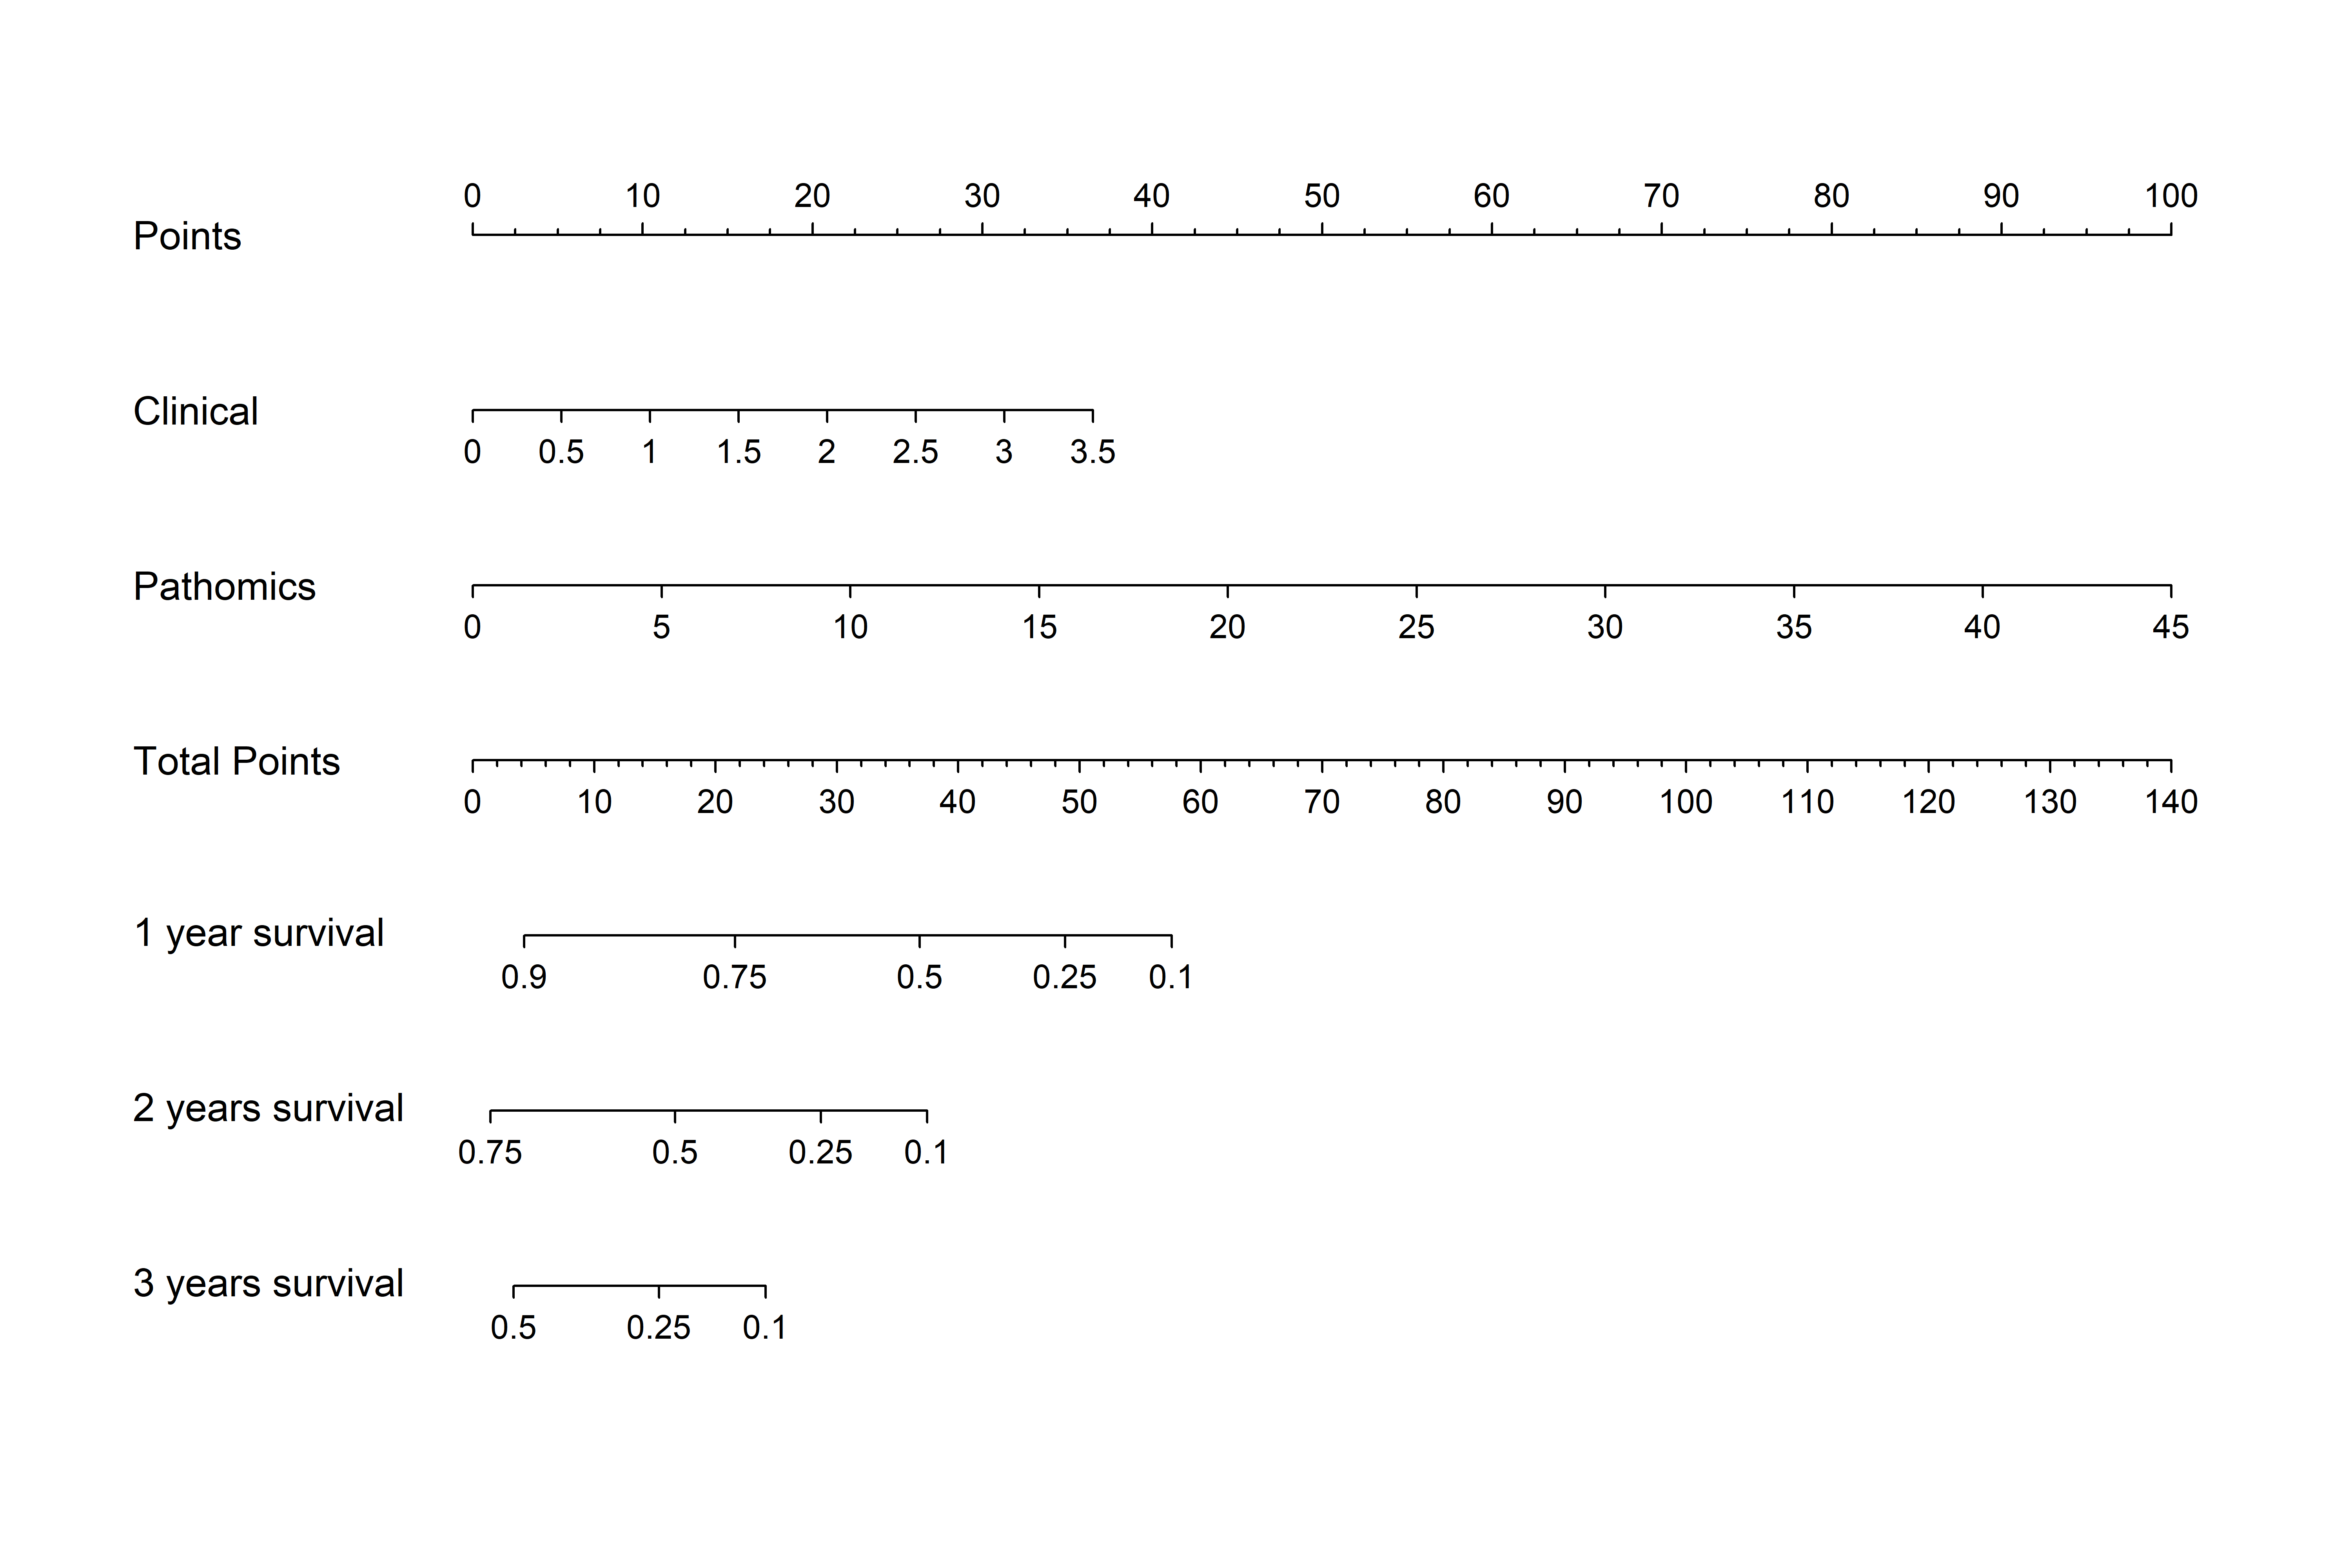

In [7]:
from onekey_algo.custom.components import nomogram

cox_data = train_data.round(decimals=2)
nomogram.nomogram(cox_data, duration=duration_col, result=event_col, 
                  columns=['Clinical', 'Pathomics'],
                  survs=[12, 12*2, 12*3], surv_names=['1 year survival','2 years survival','3 years survival'], with_r=False,
                  width=6000, height=4000, save_name='OS_nomogram.png',
                  x_range='0.1,0.25,0.5,0.75,0.9')

# nomogram.risk_nomogram(cox_data, result='survival', columns=['Clinic_Sig', 'Rad_Sig'])

# KM 曲线

根据HR进行分组，计算KM以及log ranktest

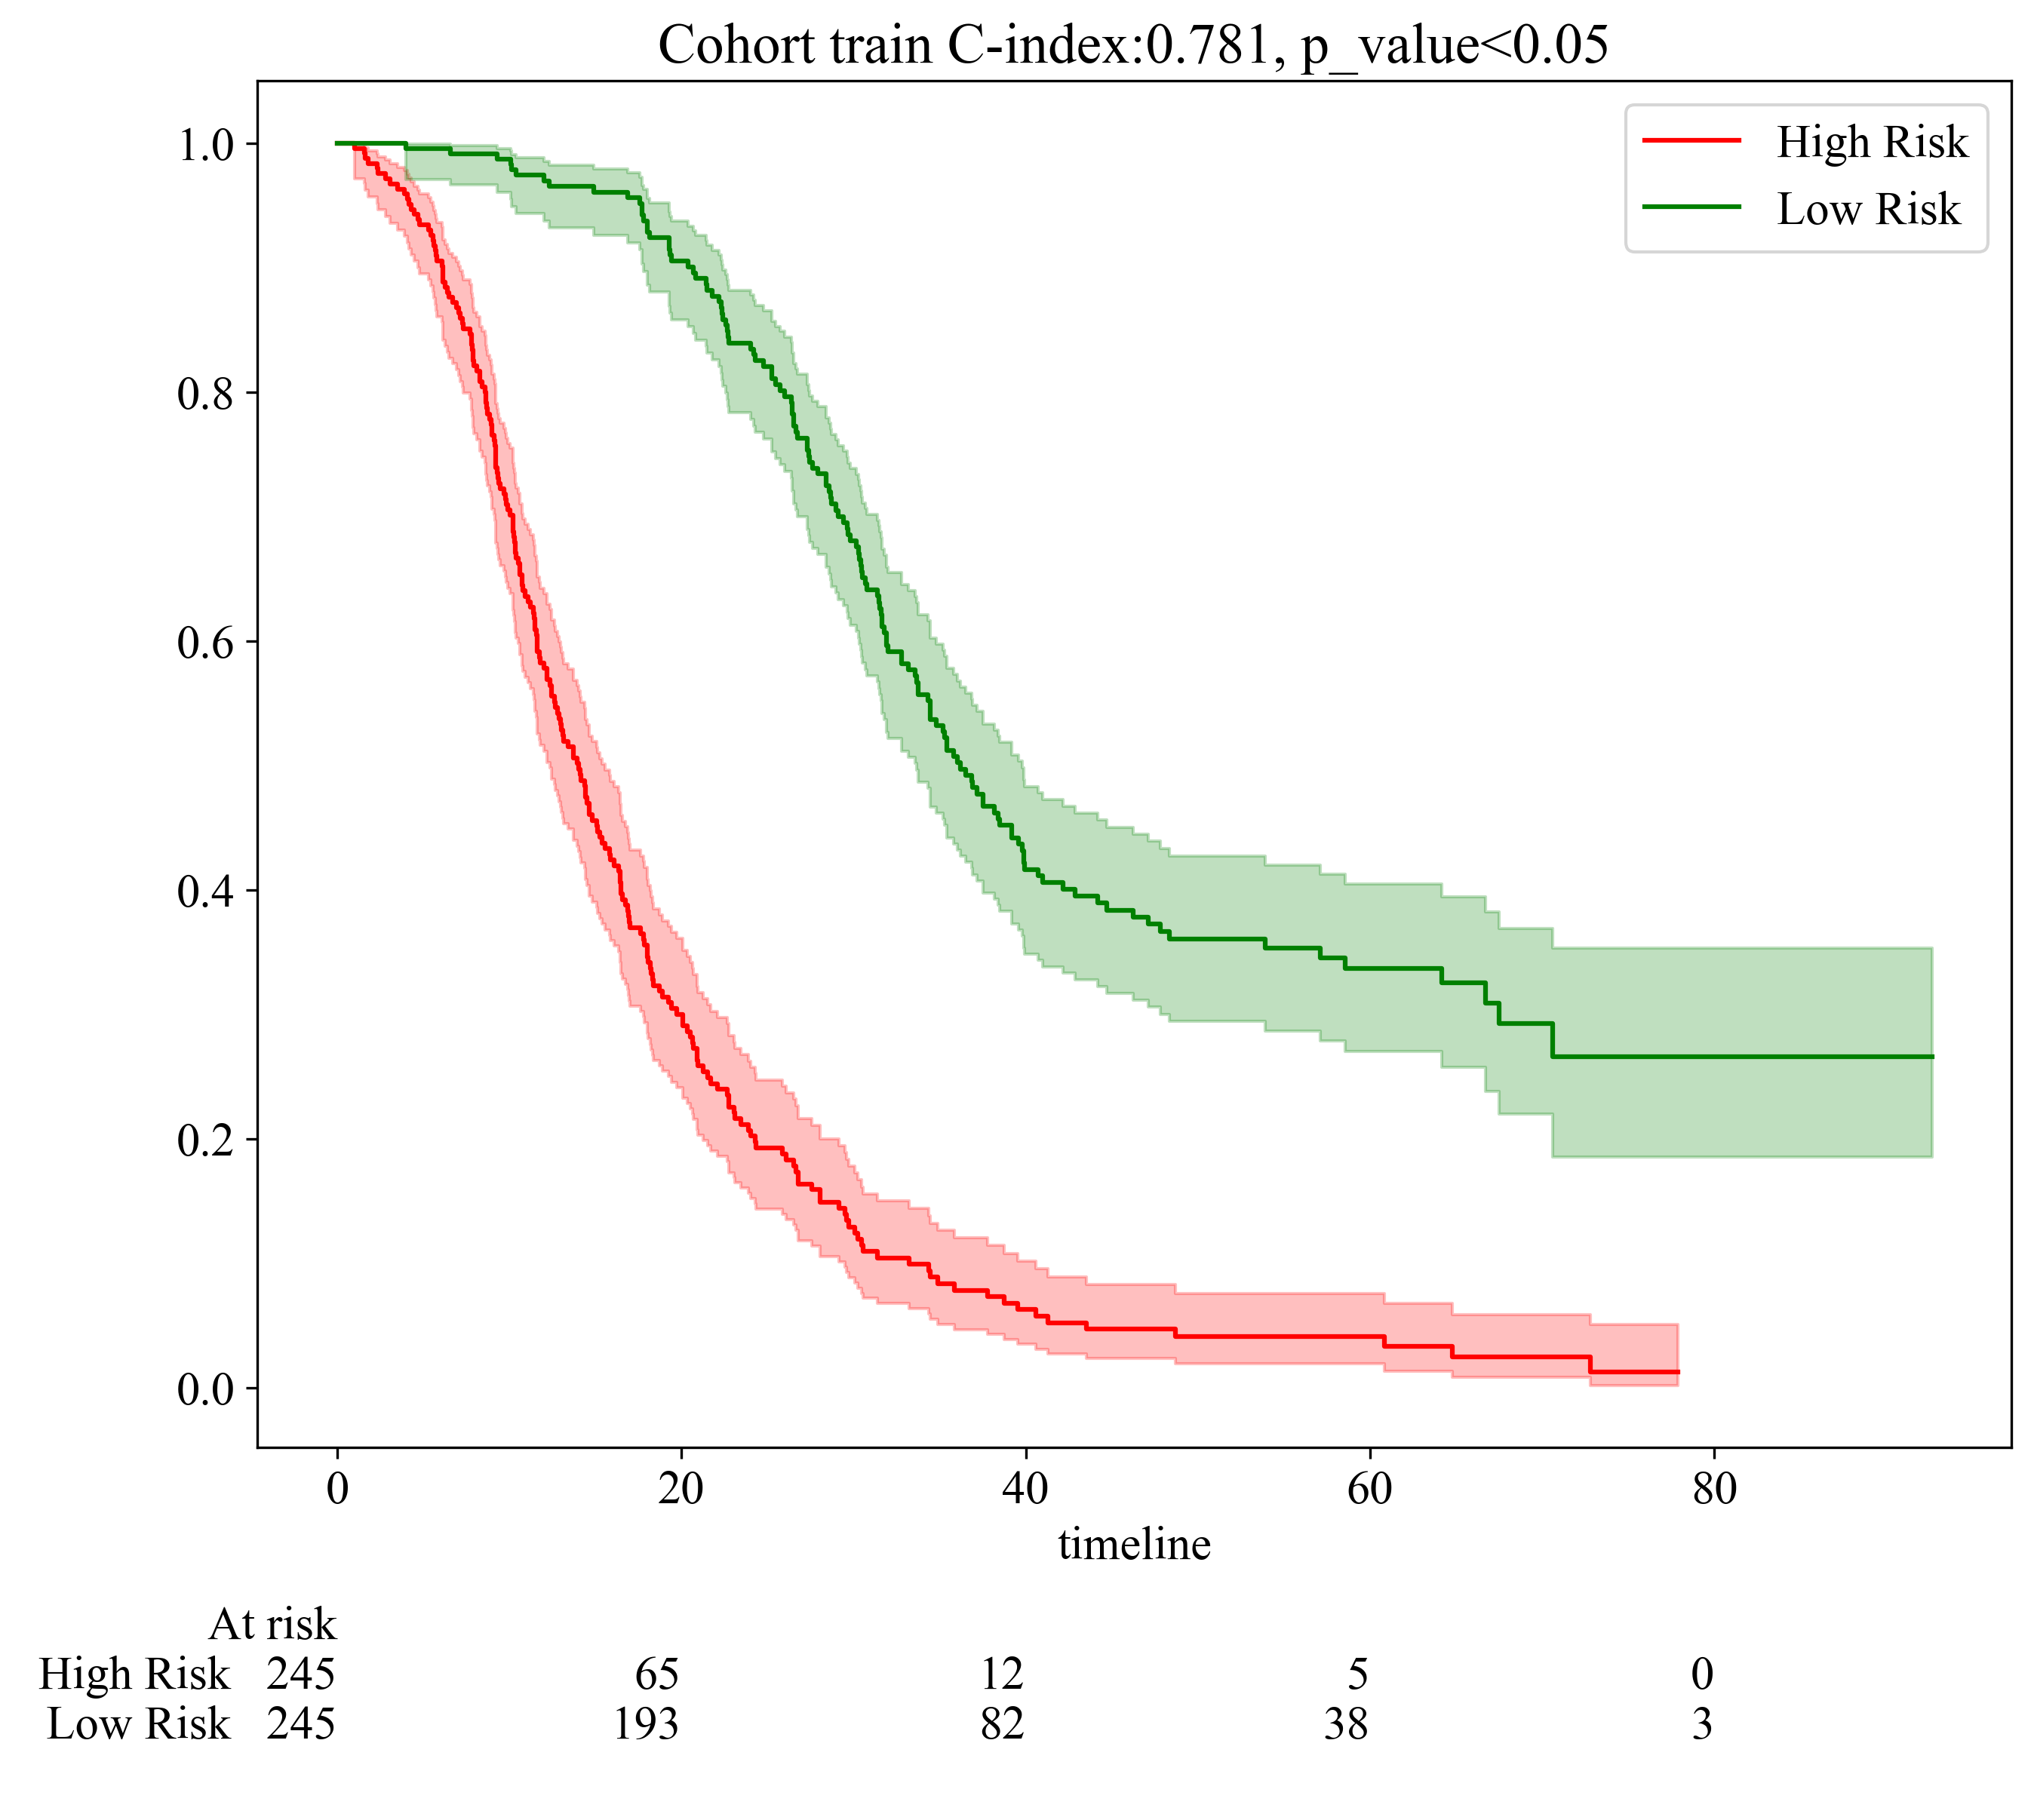

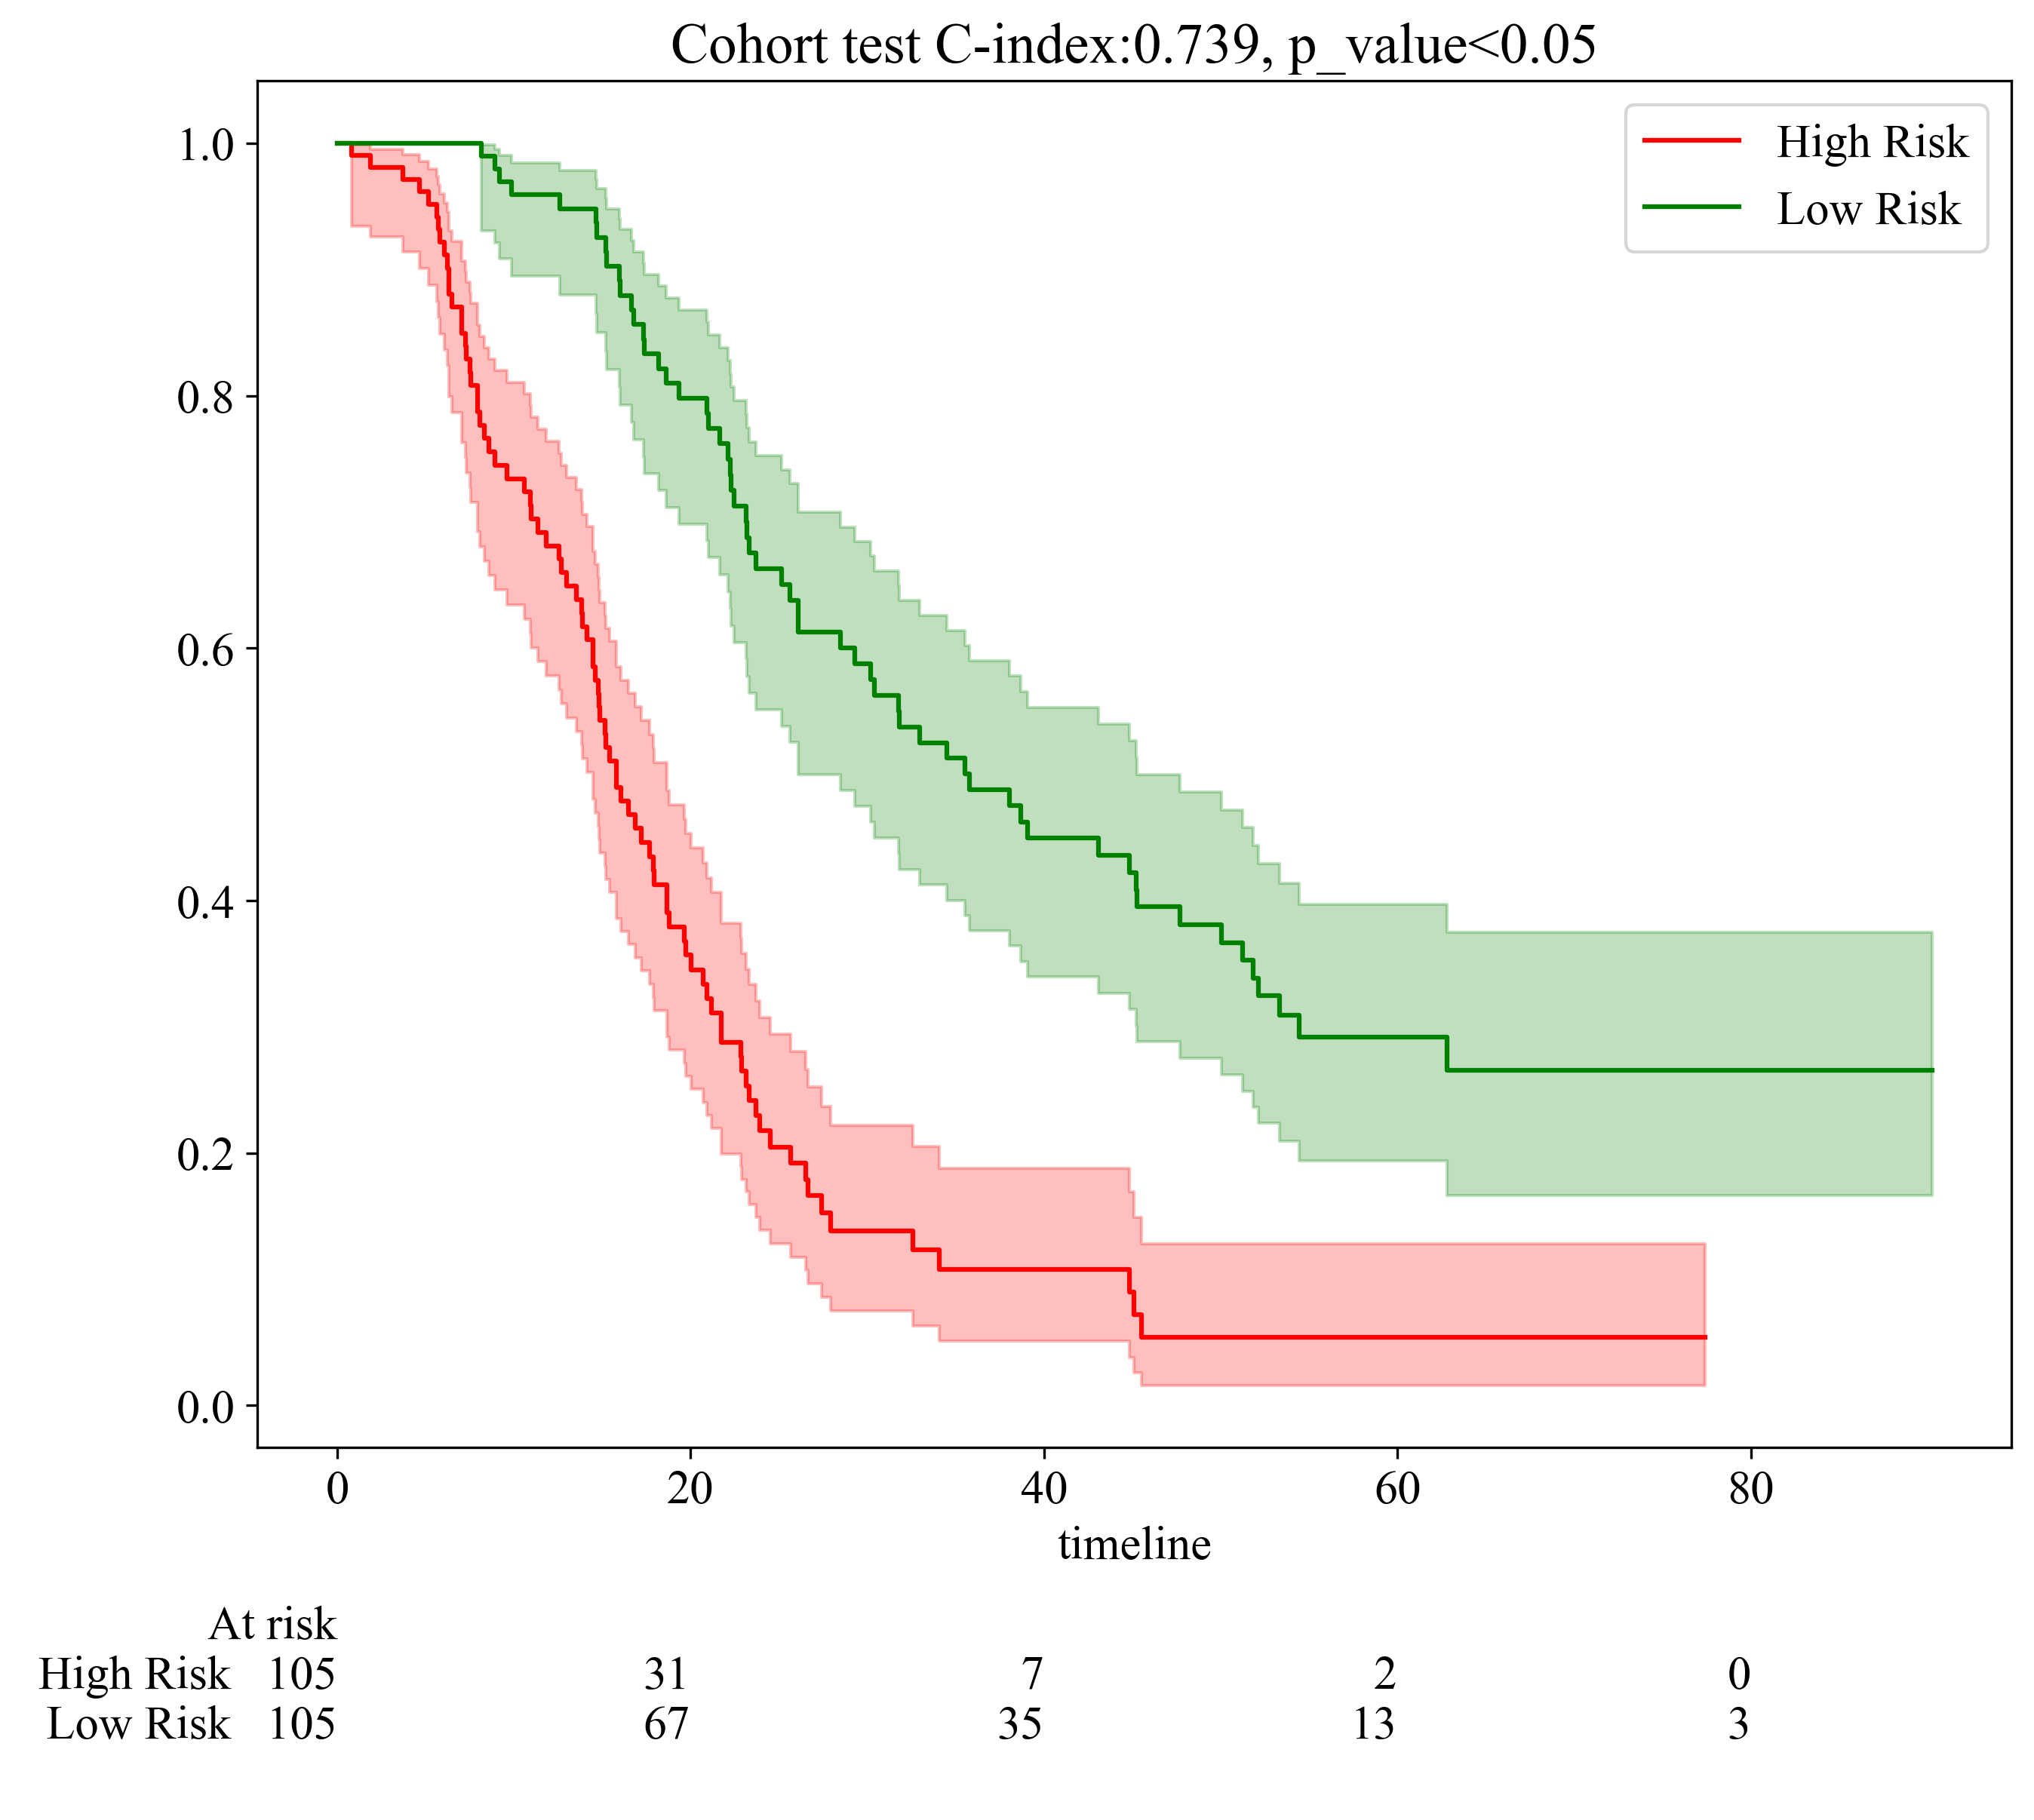

,Combined,Path,Clinical,Cohort
0,0.781,0.809,0.648,train
1,0.739,0.754,0.595,test


In [8]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import concordance_index

c_index_list = []
for subset, test_data in val_datasets.items():
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > mean
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = f"={results.p_value:.4f}" if results.p_value > 0.05 else '<0.05'
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}, p_value{p_value}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()
    c_index_list.append([c_index] + [concordance_index(cox_data[duration_col], -cox_data[mn[c]], cox_data[event_col])
                                     for c in mn.keys()] + [subset])
        
pd.DataFrame(c_index_list, columns=[task_type.strip('_')] + list(mn.keys()) + ['Cohort'])

In [34]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions
os.makedirs('results', exist_ok=True)
kids = []
for subset, test_data in val_datasets.items():
    resuslts = get_prediction(cph, test_data, ID=test_data['ID'])
    resuslts.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
    kids.append(resuslts['ID'])